<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Loading-the-input-data" data-toc-modified-id="Loading-the-input-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Loading the input data</a></span><ul class="toc-item"><li><span><a href="#Marking-outliers" data-toc-modified-id="Marking-outliers-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Marking outliers</a></span></li></ul></li><li><span><a href="#Autoencoder" data-toc-modified-id="Autoencoder-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Autoencoder</a></span></li></ul></div>

# Elo Merchant Category Recommendation - Autoencoder
End date: _2019. february 19._<br/>

This tutorial notebook is the second part of a seriers for [Elo Mechant Category Recommendation](https://www.kaggle.com/c/elo-merchant-category-recommendation) contest organized by Elo, one of the largest payment brands in Brazil. It has built partnerships with merchants in order to offer promotions or discounts to cardholders. The objective of the competition is to identify and serve the most relevant opportunities to individuals, by uncovering signals in customer loyalty. The input files are available from the [download](https://www.kaggle.com/c/elo-merchant-category-recommendation/data) section of the contest:

- **train.csv**,  **test.csv**: list of `card_ids` that can be used for training and testing
- **historical_transactions.csv**: contains up to 3 months' worth of transactions for every card at any of the provided `merchant_ids`
- **new_merchant_transactions.csv**: contains the transactions at new merchants (`merchant_ids` that this particular `card_id` 
has not yet visited) over a period of two months
- **merchants.csv**: contains aggregate information for each `merchant_id` represented in the data set

In [48]:
import gc
import math
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import tensorflow as tf
from pylab import rcParams
from keras import regularizers
import matplotlib.pyplot as plt
from keras.layers import Input, Dense
from keras.models import Model, load_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Starting memory usage: {:5.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min >= np.iinfo(np.int64).min and c_max <= np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min >= np.finfo(np.float16).min and c_max <= np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Reduced memory usage: {:5.2f} MB ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## Loading the input data

In [3]:
df_merch = pd.read_csv("input/merchants.csv")
print("{:,} records and {} features in merchant set.".format(df_merch.shape[0], df_merch.shape[1]))

334,696 records and 22 features in merchant set.


In [4]:
df_merch['category_1'] = df_merch['category_1'].map({'N': 0, 'Y': 1})
df_merch['category_2'] = pd.to_numeric(df_merch['category_2'])
df_merch['category_4'] = df_merch['category_4'].map({'N': 0, 'Y': 1})
df_merch['most_recent_sales_range'] = df_merch['most_recent_sales_range'].map({'E': 0, 'D': 1, 'C': 2, 'B': 3, 'A': 4})
df_merch['most_recent_purchases_range'] = df_merch['most_recent_purchases_range'].map({'E': 0, 'D': 1, 'C': 2, 'B': 3, 'A': 4})

In [5]:
dropping = ['city_id', 'state_id']
for var in dropping:
    df_merch = df_merch.drop(var, axis=1)

In [6]:
df_merch = reduce_mem_usage(df_merch)

Starting memory usage: 51.07 MB
Reduced memory usage: 20.43 MB (60.0% reduction)


In [7]:
df_new_trans = pd.read_csv("input/trans_merch_new_agg.csv", index_col=0)
df_new_trans = reduce_mem_usage(df_new_trans)

df_hist_trans = pd.read_csv("input/trans_merch_hist_agg.csv", index_col=0)
df_hist_trans = reduce_mem_usage(df_hist_trans)

Starting memory usage: 354.01 MB
Reduced memory usage: 84.35 MB (76.2% reduction)
Starting memory usage: 397.39 MB
Reduced memory usage: 112.08 MB (71.8% reduction)


In [8]:
df_train = pd.read_csv("input/train.csv")
df_train = reduce_mem_usage(df_train)

df_test = pd.read_csv("input/test.csv")
df_test = reduce_mem_usage(df_test)

print("{:,} records and {} features in train set.".format(df_train.shape[0], df_train.shape[1]))
print("{:,} records and {} features in test set.".format(df_test.shape[0], df_test.shape[1]))

Starting memory usage:  9.24 MB
Reduced memory usage:  4.04 MB (56.2% reduction)
Starting memory usage:  4.72 MB
Reduced memory usage:  2.24 MB (52.5% reduction)
201,917 records and 6 features in train set.
123,623 records and 5 features in test set.


In [9]:
df_train = pd.merge(df_train, df_hist_trans, on='card_id',how='left')
df_test = pd.merge(df_test, df_hist_trans, on='card_id',how='left')

df_train = pd.merge(df_train, df_new_trans, on='card_id', how='left')
df_test = pd.merge(df_test, df_new_trans, on='card_id', how='left')

In [10]:
del df_hist_trans
del df_new_trans
gc.collect()

67

In [11]:
df_train[:3]

,first_active_month,card_id,feature_1,feature_2,feature_3,target,hist_transactions_count,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_active_months_lag3_sum,...,new_purchase_dayofweek_max,new_purchase_dayofweek_min,new_purchase_dayofweek_std,new_purchase_dayofweek_mode,new_purchase_quarter_mean,new_purchase_quarter_median,new_purchase_quarter_max,new_purchase_quarter_min,new_purchase_quarter_std,new_purchase_quarter_mode
0,2017-06,C_ID_92a2005557,5,2,1,-0.820312,1,252.0,0.951172,777.0,...,6.0,0.0,2.029297,4.0,1.478516,1.0,2.0,1.0,0.510742,1.0
1,2017-01,C_ID_3d0044924f,4,1,0,0.392822,1,354.0,0.969727,1095.0,...,4.0,0.0,1.643555,0.0,1.000000,1.0,1.0,1.0,0.000000,1.0
2,2016-08,C_ID_d639edf6cd,2,2,0,0.687988,1,42.0,0.954590,132.0,...,5.0,5.0,NaN,5.0,2.000000,2.0,2.0,2.0,NaN,2.0


In [12]:
df_test[:3]

,first_active_month,card_id,feature_1,feature_2,feature_3,hist_transactions_count,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_active_months_lag3_sum,hist_active_months_lag3_mean,...,new_purchase_dayofweek_max,new_purchase_dayofweek_min,new_purchase_dayofweek_std,new_purchase_dayofweek_mode,new_purchase_quarter_mean,new_purchase_quarter_median,new_purchase_quarter_max,new_purchase_quarter_min,new_purchase_quarter_std,new_purchase_quarter_mode
0,2017-04,C_ID_0ab67a22ab,3,3,1,1,47.0,0.662109,213.0,3.0,...,5.0,2.0,1.527344,2.0,1.000000,1.0,1.0,1.0,0.000000,1.0
1,2017-01,C_ID_130fd0cbdd,2,3,0,1,77.0,0.987305,234.0,3.0,...,6.0,0.0,2.359375,0.0,1.400391,1.0,2.0,1.0,0.516602,1.0
2,2017-08,C_ID_b709037bc5,5,1,1,1,9.0,0.692383,39.0,3.0,...,3.0,1.0,1.414062,1.0,1.000000,1.0,1.0,1.0,0.000000,1.0


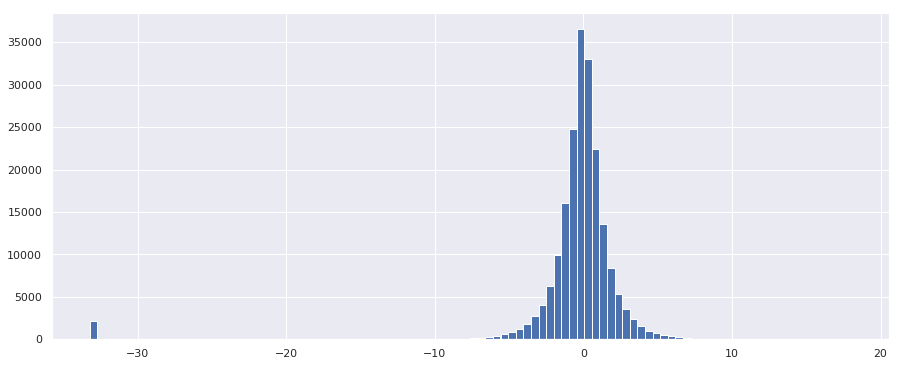

In [13]:
sns.set(rc={'figure.figsize':(15, 6)})

df_train['target'].hist(bins=100)

### Marking outliers

In [14]:
df_train['is_outlier'] = df_train['target'].apply(lambda x: True if x < -30 else False)

In [15]:
len(df_train[df_train['is_outlier'] == True]['is_outlier'])

2207

https://medium.com/@curiousily/credit-card-fraud-detection-using-autoencoders-in-keras-tensorflow-for-hackers-part-vii-20e0c85301bd

Text(0, 0.5, 'Frequency')

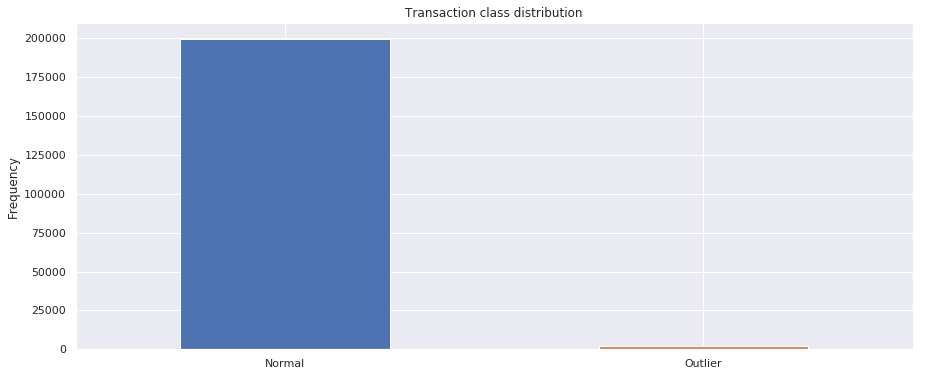

In [16]:
count_classes = pd.value_counts(df_train['is_outlier'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), ["Normal", "Outlier"])
plt.ylabel("Frequency")

## Filtering

In [17]:
df_train.drop(columns=['card_id', 'first_active_month', 'hist_merchant_id_mode', 'new_merchant_id_mode'], inplace=True, axis=1)
df_test.drop(columns=['card_id', 'first_active_month', 'hist_merchant_id_mode', 'new_merchant_id_mode'], inplace=True, axis=1)

In [18]:
len(df_train), len(df_test)

(201917, 123623)

In [19]:
df_train.dropna(how='any', axis=0, inplace=True)
df_test.dropna(how='any', axis=0, inplace=True)

In [20]:
len(df_train), len(df_test)

(147718, 90384)

In [24]:
list(df_train.columns)

['feature_1',
 'feature_2',
 'feature_3',
 'target',
 'hist_transactions_count',
 'hist_authorized_flag_sum',
 'hist_authorized_flag_mean',
 'hist_active_months_lag3_sum',
 'hist_active_months_lag3_mean',
 'hist_active_months_lag6_sum',
 'hist_active_months_lag6_mean',
 'hist_active_months_lag12_sum',
 'hist_active_months_lag12_mean',
 'hist_avg_sales_lag3_sum',
 'hist_avg_sales_lag3_mean',
 'hist_avg_sales_lag6_sum',
 'hist_avg_sales_lag6_mean',
 'hist_avg_sales_lag12_sum',
 'hist_avg_sales_lag12_mean',
 'hist_category_1_trans_sum',
 'hist_category_1_trans_mean',
 'hist_category_1_merch_sum',
 'hist_category_1_merch_mean',
 'hist_category_2_trans_sum',
 'hist_category_2_trans_mean',
 'hist_category_2_trans_mode',
 'hist_category_2_trans_nancnt',
 'hist_category_2_trans_nanperc',
 'hist_category_2_merch_sum',
 'hist_category_2_merch_mean',
 'hist_category_2_merch_mode',
 'hist_category_2_merch_nancnt',
 'hist_category_2_merch_nanperc',
 'hist_category_3_sum',
 'hist_category_3_mean',
 

In [21]:
for f in df_train.columns:
    if f != 'is_outlier':
        mean = df_train[f].mean()
        std = df_train[f].std()
        if math.isnan(mean):
            mean = df_train[f].astype(int).mean()
            std = df_train[f].astype(int).std()
    
        df_train[f] = (df_train[f] - mean)/std
        print('{}: {:.4f} ({:.4f})'.format(f, mean, std))

feature_1: 3.0877 (1.1951)
feature_2: 1.7326 (0.7500)
feature_3: 0.5543 (0.4970)
target: -0.4637 (3.0914)
hist_transactions_count: 1.0000 (0.0000)
hist_authorized_flag_sum: 96.7168 (111.3211)
hist_authorized_flag_mean: 0.1419 (0.3490)
hist_active_months_lag3_sum: 313.4754 (349.7907)
hist_active_months_lag3_mean: 2.9866 (0.1149)
hist_active_months_lag6_sum: 626.7824 (699.3774)
hist_active_months_lag6_mean: 5.9466 (0.2249)
hist_active_months_lag12_sum: 1229.6961 (1374.6195)
hist_active_months_lag12_mean: 11.1854 (0.4336)
hist_avg_sales_lag3_sum: 13026.3418 (150941.2031)
hist_avg_sales_lag3_mean: 130.5023 (1961.9861)
hist_avg_sales_lag6_sum: 12329.6572 (141868.8281)
hist_avg_sales_lag6_mean: 123.9150 (1847.1615)
hist_avg_sales_lag12_sum: 11424.0674 (138272.3594)
hist_avg_sales_lag12_mean: 114.8046 (1782.2146)
hist_avg_purchases_lag3_sum: inf (nan)
hist_avg_purchases_lag3_mean: inf (nan)
hist_avg_purchases_lag6_sum: inf (nan)
hist_avg_purchases_lag6_mean: inf (nan)
hist_avg_purchases_lag12

new_category_2_trans_nanperc: 4.6427 (12.1898)
new_category_2_merch_sum: 15.9339 (19.8446)
new_category_2_merch_mean: 2.1792 (1.4587)
new_category_2_merch_mode: 2.2388 (1.5272)
new_category_2_merch_nancnt: 0.9026 (1.3522)
new_category_2_merch_nanperc: 11.9043 (16.9196)
new_category_3_sum: 4.6446 (7.0415)
new_category_3_mean: 0.5316 (0.5310)
new_category_3_mode: 0.5587 (0.5738)
new_category_3_nancnt: 0.0000 (0.0000)
new_category_3_nanperc: 3.1530 (9.2390)
new_category_4_sum: 4.0277 (5.1978)
new_category_4_mean: 0.2198 (0.4141)
new_city_id_nunique: 2.5745 (1.7250)
new_city_id_mode: 129.5956 (99.5631)
new_city_id_nancnt: 0.0000 (0.0000)
new_city_id_nanperc: 0.0000 (0.0000)
new_installments_sum: 5.4636 (9.0421)
new_installments_median: 0.5913 (0.7818)
new_installments_mean: 0.5650 (0.8297)
new_installments_max: 1.5609 (3.5678)
new_installments_min: 0.2161 (0.7393)
new_installments_std: 0.3332 (0.9593)
new_installments_mode: 0.5047 (0.7122)
new_installments_nancnt: 0.0000 (0.0000)
new_insta

## Autoencoder

In [44]:
df_train[[ 'new_purchase_weekofyear_mean',
 'new_purchase_weekofyear_median',
 'new_purchase_weekofyear_max',
 'new_purchase_weekofyear_min',
 'new_purchase_weekofyear_std',
 'new_purchase_weekofyear_mode',
 'new_purchase_dayofweek_mean',
 'new_purchase_dayofweek_median',
 'new_purchase_dayofweek_max',
 'new_purchase_dayofweek_min',
 'new_purchase_dayofweek_mode',
 'new_purchase_quarter_mean',
 'new_purchase_quarter_median',
 'new_purchase_quarter_max',
 'new_purchase_quarter_min',
 'new_purchase_quarter_mode',]].describe()

,new_purchase_weekofyear_mean,new_purchase_weekofyear_median,new_purchase_weekofyear_max,new_purchase_weekofyear_min,new_purchase_weekofyear_std,new_purchase_weekofyear_mode,new_purchase_dayofweek_mean,new_purchase_dayofweek_median,new_purchase_dayofweek_max,new_purchase_dayofweek_min,new_purchase_dayofweek_mode,new_purchase_quarter_mean,new_purchase_quarter_median,new_purchase_quarter_max,new_purchase_quarter_min,new_purchase_quarter_mode
count,147718.000000,147718.000000,147718.000000,147718.000000,147718.000000,147718.000000,147718.000000,147718.000000,147718.000000,147718.000000,147718.000000,147718.000000,147718.000000,147718.000000,147718.000000,147718.000000
mean,-0.000000,-0.000000,-1.759134,-1.330161,-0.000000,-1.446853,0.000000,0.000000,-4.089826,-0.732765,-1.378108,0.000000,-0.000000,-2.533909,-1.681855,-1.842056
std,0.000000,0.000000,0.093195,0.104104,0.000000,0.096038,0.000000,0.000000,0.815691,0.744687,0.517600,0.000000,0.000000,1.258254,1.244323,1.142919
min,-2.248047,-2.121094,-1.914335,-1.457884,-0.828125,-1.576447,-3.943359,-3.457031,-7.475825,-1.277856,-2.092834,-0.970703,-1.620117,-4.144809,-2.228595,-2.640926
25%,-0.777344,-0.868164,-1.801892,-1.371541,-0.374268,-1.493887,-0.615723,-1.278320,-4.107176,-1.277856,-1.824619,-0.647949,-1.620117,-2.562835,-2.228595,-2.640926
50%,-0.581543,-0.617676,-1.784593,-1.360748,-0.144287,-1.475541,0.231323,-0.187622,-4.107176,-1.277856,-1.288188,-0.164429,-0.598633,-2.562835,-2.228595,-2.640926
75%,-0.365967,-0.367188,-1.775943,-1.339162,0.035095,-1.438848,1.144531,0.902344,-3.433446,-0.164644,-1.019972,0.319092,0.421143,-2.562835,-2.228595,-1.339234
max,4.687500,4.269531,-1.473210,-0.907449,10.359375,-1.108608,4.136719,3.083984,-3.433446,2.061780,-0.483541,3.865234,4.500000,0.601113,2.385664,1.264150


In [45]:
cols = ['feature_1',
 'feature_2',
 'feature_3',
 'hist_authorized_flag_sum',
 'hist_active_months_lag3_sum',
 'hist_active_months_lag6_sum',
 'hist_active_months_lag12_sum',
 'hist_avg_sales_lag3_sum',
 'hist_avg_sales_lag3_mean',
 'hist_avg_sales_lag6_sum',
 'hist_avg_sales_lag6_mean',
 'hist_avg_sales_lag12_sum',
 'hist_avg_sales_lag12_mean',
 'hist_category_1_trans_sum',
 'hist_category_1_merch_sum',
 'hist_category_2_trans_sum',
 'hist_category_2_trans_mean',
 'hist_category_2_trans_nancnt',
 'hist_category_2_trans_nanperc',
 'hist_category_2_merch_sum',
 'hist_category_2_merch_mean',
 'hist_category_2_merch_nancnt',
 'hist_category_2_merch_nanperc',
 'hist_category_3_sum',
 'hist_category_3_nanperc',
 'hist_category_4_sum',
 'hist_city_id_nunique',
 'hist_city_id_mode',
 'hist_installments_sum',
 'hist_installments_mean',
 'hist_installments_max',
 'hist_installments_min',
 'hist_installments_std',
 'hist_installments_mode',
 'hist_merchant_id_nunique',
 'hist_merchant_id_nancnt',
 'hist_merchant_category_id_trans_nunique',
 'hist_merchant_category_id_trans_mode',
 'hist_merchant_group_id_nunique',
 'hist_merchant_group_id_mode',
 'hist_merchant_category_id_merch_nunique',
 'hist_merchant_category_id_merch_mode',
 'hist_month_lag_min',
 'hist_month_lag_max',
 'hist_month_lag_mean',
 'hist_most_recent_sales_range_sum',
 'hist_most_recent_sales_range_max',
 'hist_most_recent_sales_range_mode',
 'hist_most_recent_purchases_range_sum',
 'hist_most_recent_purchases_range_max',
 'hist_most_recent_purchases_range_mode',
 'hist_numerical_1_mean',
 'hist_numerical_1_std',
 'hist_numerical_1_mode',
 'hist_numerical_2_mean',
 'hist_numerical_2_std',
 'hist_state_id_nunique',
 'hist_state_id_mode',
 'hist_subsector_id_trans_nunique',
 'hist_subsector_id_trans_mode',
 'hist_subsector_id_merch_nunique',
 'hist_subsector_id_merch_mode',
 'hist_purchase_amount_sum',
 'hist_purchase_amount_mean',
 'hist_purchase_amount_max',
 'hist_purchase_amount_std',
 'hist_purchase_year_mean',
 'hist_purchase_year_median',
 'hist_purchase_year_max',
 'hist_purchase_year_mode',
 'hist_purchase_month_mean',
 'hist_purchase_month_median',
 'hist_purchase_month_max',
 'hist_purchase_month_min',
 'hist_purchase_month_std',
 'hist_purchase_month_mode',
 'hist_purchase_day_mean',
 'hist_purchase_day_median',
 'hist_purchase_day_max',
 'hist_purchase_day_min',
 'hist_purchase_day_std',
 'hist_purchase_day_mode',
 'hist_purchase_hour_mean',
 'hist_purchase_hour_median',
 'hist_purchase_hour_max',
 'hist_purchase_hour_min',
 'hist_purchase_hour_std',
 'hist_purchase_hour_mode',
 'hist_purchase_weekofyear_mean',
 'hist_purchase_weekofyear_median',
 'hist_purchase_weekofyear_max',
 'hist_purchase_weekofyear_min',
 'hist_purchase_weekofyear_std',
 'hist_purchase_weekofyear_mode',
 'hist_purchase_dayofweek_median',
 'hist_purchase_dayofweek_max',
 'hist_purchase_dayofweek_min',
 'hist_purchase_dayofweek_mode',
 'hist_purchase_quarter_median',
 'hist_purchase_quarter_max',
 'hist_purchase_quarter_min',
 'hist_purchase_quarter_mode',
 'new_authorized_flag_sum',
 'new_active_months_lag3_sum',
 'new_active_months_lag3_mean',
 'new_active_months_lag6_sum',
 'new_active_months_lag12_sum',
 'new_avg_sales_lag3_sum',
 'new_avg_sales_lag3_mean',
 'new_avg_sales_lag6_sum',
 'new_avg_sales_lag6_mean',
 'new_avg_sales_lag12_sum',
 'new_avg_sales_lag12_mean',
 'new_avg_purchases_lag3_sum',
 'new_avg_purchases_lag3_mean',
 'new_avg_purchases_lag6_sum',
 'new_avg_purchases_lag6_mean',
 'new_avg_purchases_lag12_sum',
 'new_avg_purchases_lag12_mean',
 'new_category_1_trans_sum',
 'new_category_1_merch_sum',
 'new_category_2_trans_sum',
 'new_category_2_trans_mean',
 'new_category_2_trans_nanperc',
 'new_category_2_merch_sum',
 'new_category_2_merch_nancnt',
 'new_category_2_merch_nanperc',
 'new_category_3_sum',
 'new_category_3_nanperc',
 'new_category_4_sum',
 'new_city_id_nunique',
 'new_city_id_mode',
 'new_installments_sum',
 'new_installments_max',
 'new_installments_min',
 'new_installments_mode',
 'new_merchant_id_nunique',
 'new_merchant_id_nancnt',
 'new_merchant_id_nanperc',
 'new_merchant_category_id_trans_nunique',
 'new_merchant_category_id_trans_mode',
 'new_merchant_group_id_nunique',
 'new_merchant_group_id_mode',
 'new_merchant_group_id_nanperc',
 'new_merchant_category_id_merch_nunique',
 'new_merchant_category_id_merch_mode',
 'new_merchant_category_id_merch_nanperc',
 'new_month_lag_min',
 'new_month_lag_max',
 'new_most_recent_sales_range_sum',
 'new_most_recent_sales_range_max',
 'new_most_recent_sales_range_mode',
 'new_most_recent_purchases_range_sum',
 'new_most_recent_purchases_range_max',
 'new_most_recent_purchases_range_min',
 'new_most_recent_purchases_range_mode',
 'new_numerical_1_mean',
 'new_numerical_1_median',
 'new_numerical_1_max',
 'new_numerical_1_std',
 'new_numerical_2_mean',
 'new_numerical_2_median',
 'new_numerical_2_max',
 'new_numerical_2_std',
 'new_state_id_nunique',
 'new_state_id_mode',
 'new_subsector_id_trans_nunique',
 'new_subsector_id_trans_mode',
 'new_subsector_id_merch_nunique',
 'new_subsector_id_merch_mode',
 'new_subsector_id_merch_nanperc',
 'new_purchase_amount_sum',
 'new_purchase_year_mean',
 'new_purchase_year_median',
 'new_purchase_year_max',
 'new_purchase_year_min',
 'new_purchase_year_mode',
 'new_purchase_month_mean',
 'new_purchase_month_median',
 'new_purchase_month_max',
 'new_purchase_month_min',
 'new_purchase_month_mode',
 'new_purchase_day_mean',
 'new_purchase_day_median',
 'new_purchase_day_max',
 'new_purchase_day_min',
 'new_purchase_day_std',
 'new_purchase_day_mode',
 'new_purchase_hour_mean',
 'new_purchase_hour_median',
 'new_purchase_hour_max',
 'new_purchase_hour_min',
 'new_purchase_hour_std',
 'new_purchase_hour_mode',
 'new_purchase_weekofyear_mean',
 'new_purchase_weekofyear_median',
 'new_purchase_weekofyear_max',
 'new_purchase_weekofyear_min',
 'new_purchase_weekofyear_std',
 'new_purchase_weekofyear_mode',
 'new_purchase_dayofweek_mean',
 'new_purchase_dayofweek_median',
 'new_purchase_dayofweek_max',
 'new_purchase_dayofweek_min',
 'new_purchase_dayofweek_mode',
 'new_purchase_quarter_mean',
 'new_purchase_quarter_median',
 'new_purchase_quarter_max',
 'new_purchase_quarter_min',
 'new_purchase_quarter_mode',
 'is_outlier']
X_train, X_test = train_test_split(df_train[cols], test_size=0.2, random_state=42)
X_train = X_train[X_train['is_outlier'] == 0]
X_train = X_train.drop(['is_outlier'], axis=1)

y_test = X_test['is_outlier']

X_test = X_test.drop(['is_outlier'], axis=1)
X_train = X_train.values
X_test = X_test.values
X_train.shape

(117289, 210)

In [46]:
input_dim = X_train.shape[1]
encoding_dim = 10

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(10e-2))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [51]:
nb_epoch = 100
batch_size = 32
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h5", verbose=0, save_best_only=True)
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
#tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, earlystopping]).history # tensorboard

Train on 117289 samples, validate on 29544 samples
Epoch 1/100
117289/117289 [==============================] - 7s 63us/step - loss: 755662.4824 - acc: 0.0102 - val_loss: 755660.3388 - val_acc: 0.0111
Epoch 2/100
117289/117289 [==============================] - 7s 56us/step - loss: 755662.4821 - acc: 0.0102 - val_loss: 755660.3383 - val_acc: 0.0111
Epoch 3/100
117289/117289 [==============================] - 7s 56us/step - loss: 755662.4818 - acc: 0.0102 - val_loss: 755660.3406 - val_acc: 0.0111
Epoch 4/100
117289/117289 [==============================] - 6s 55us/step - loss: 755662.4825 - acc: 0.0102 - val_loss: 755660.3398 - val_acc: 0.0111
Epoch 5/100
117289/117289 [==============================] - 9s 76us/step - loss: 755662.4826 - acc: 0.0102 - val_loss: 755660.3403 - val_acc: 0.0111
Epoch 6/100
117289/117289 [==============================] - 7s 59us/step - loss: 755662.4828 - acc: 0.0102 - val_loss: 755660.3392 - val_acc: 0.0111
Epoch 7/100
117289/117289 [======================

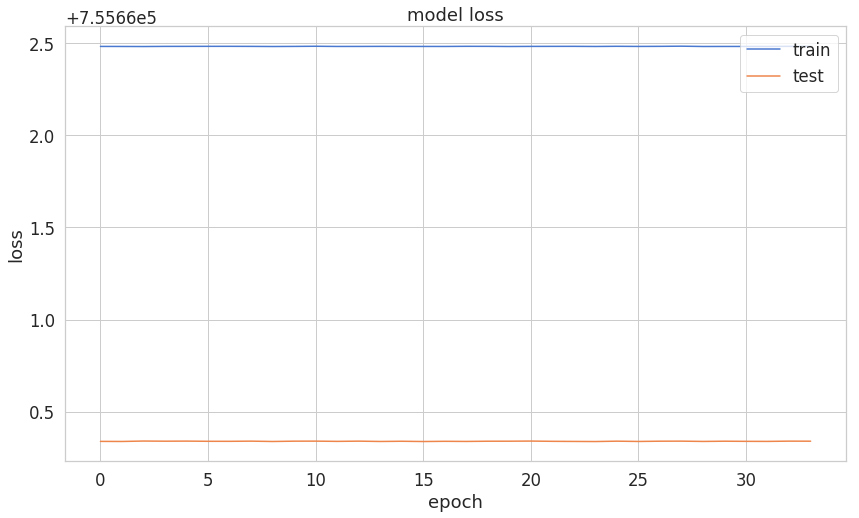

In [52]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [53]:
y_test = y_test.map({False: 0, True: 1})

In [54]:
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({
    'reconstruction_error': mse,
    'true_class': y_test
})
error_df.describe()

,reconstruction_error,true_class
count,29544.000000,29544.000000
mean,755628.385046,0.008123
std,592.351382,0.089765
min,754906.428623,0.000000
25%,755446.907352,0.000000
50%,755447.460015,0.000000
75%,755450.516680,0.000000
max,757504.322946,1.000000


Text(0.5, 1.0, 'Reconstruction error without outliers')

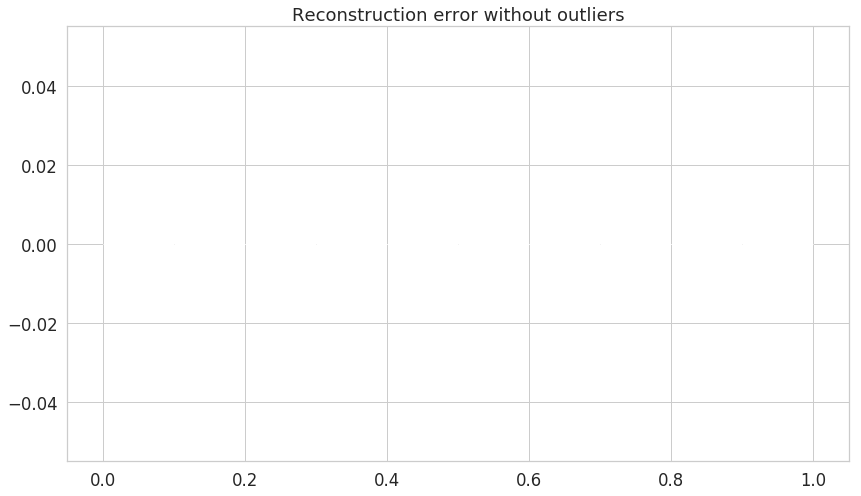

In [55]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)
ax.set_title('Reconstruction error without outliers')

Text(0.5, 1.0, 'Reconstruction error with outliers')

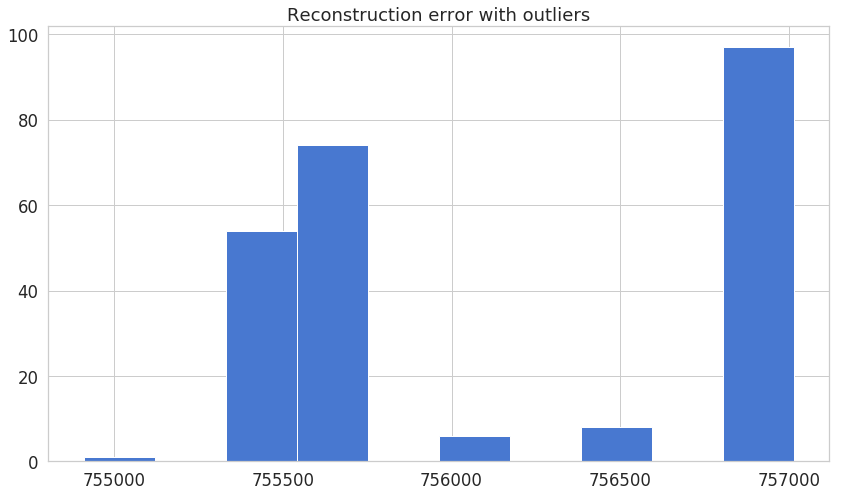

In [56]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)
ax.set_title('Reconstruction error with outliers')

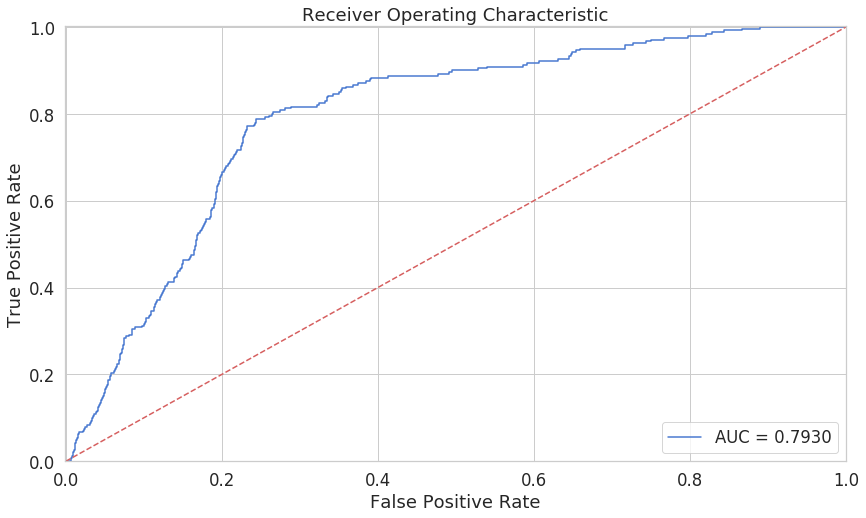

In [57]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

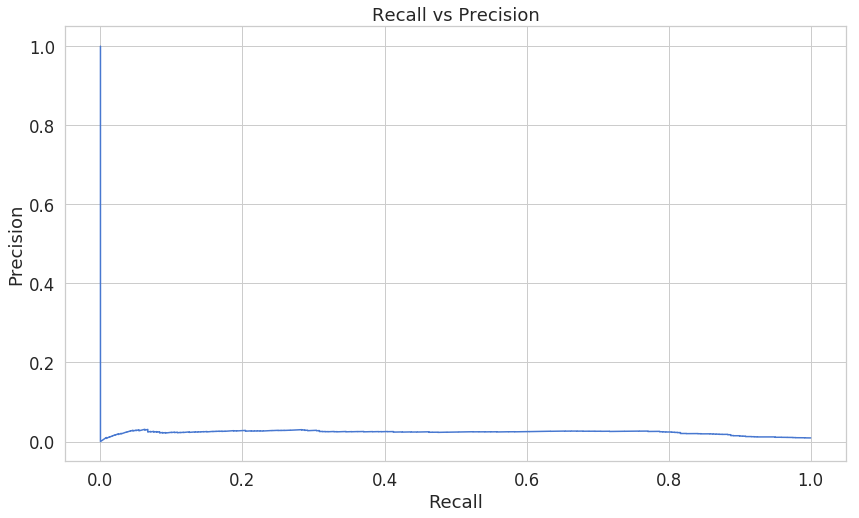

In [58]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

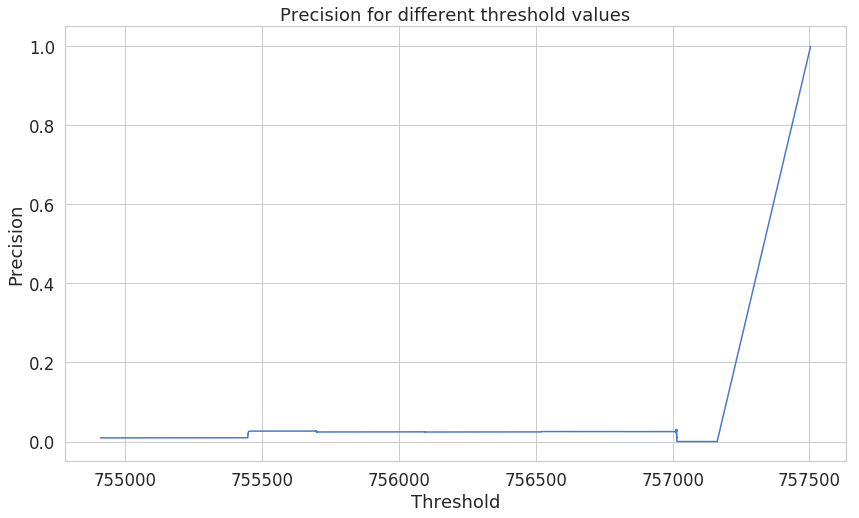

In [59]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

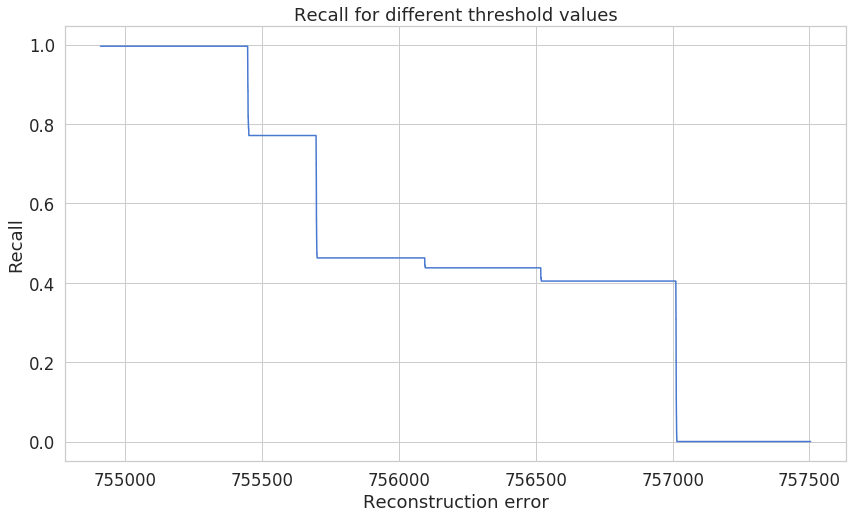

In [60]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

In [85]:
threshold = 757020

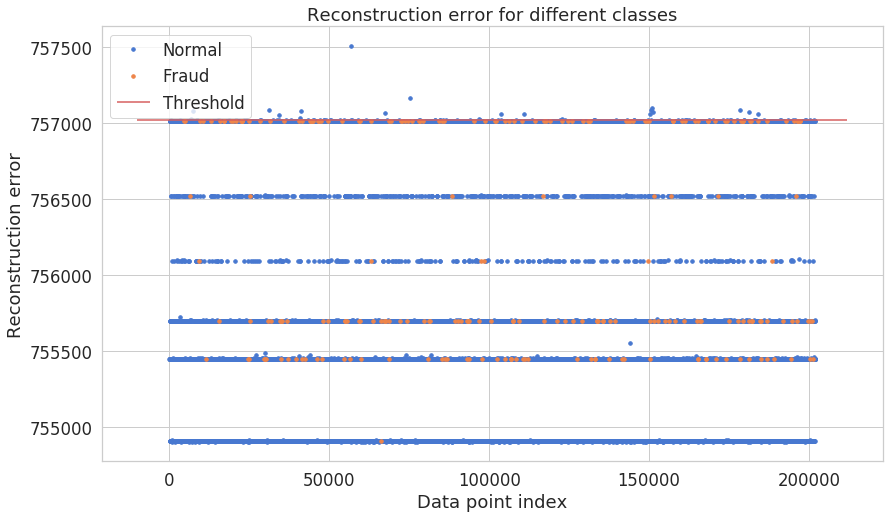

In [86]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

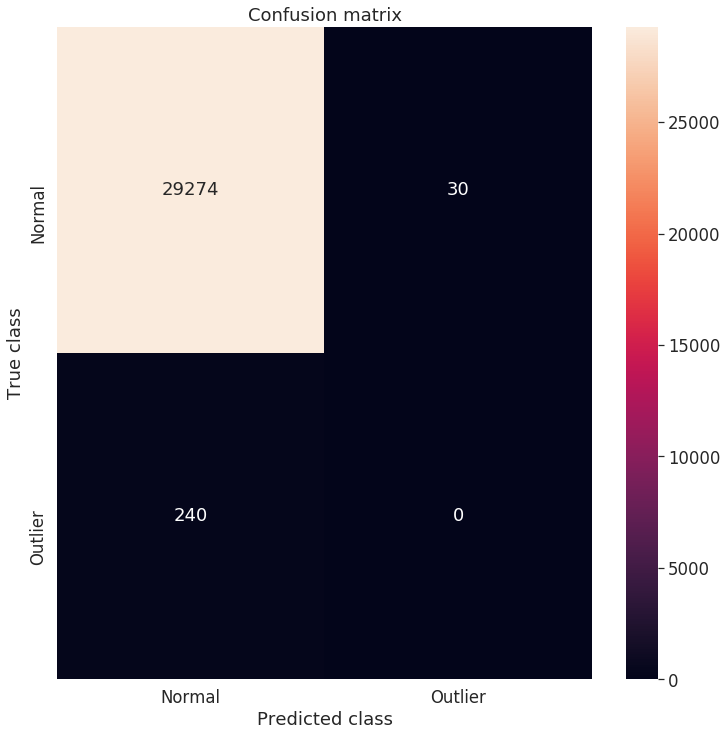

In [87]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=["Normal", "Outlier"], yticklabels=["Normal", "Outlier"], annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()